In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
import torch.nn.functional as F

from skimage.segmentation import mark_boundaries

!pip install lime
from lime import lime_image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

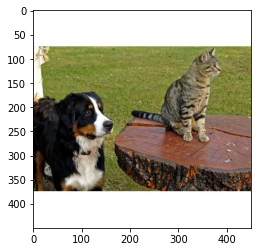

In [3]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('./dogs.png')
plt.imshow(img)
plt.show()

# Define Model

In [4]:
model = models.resnet152(pretrained=True)

In [5]:
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    return transf(img).unsqueeze(0)

In [6]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('./imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}


In [7]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

# LIME

In [8]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [9]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [10]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

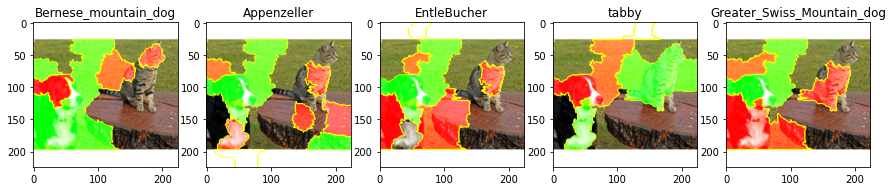

In [11]:
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 5)

ax = np.empty([5], dtype=object)
for i in range(5):
      ax[i] = fig.add_subplot(gs[i])

for i in range(5):
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[i], 
                                                positive_only=False, 
                                                num_features=10, 
                                                hide_rest=False)
    img_boundry2 = mark_boundaries(temp/255.0, mask)
    ax[i].imshow(img_boundry2)
    
    ax[i].set_title(idx2label[explanation.top_labels[i]])

plt.show()